# Starting to explore eqcorrscan

## Started off by making a quakeml file for a small subset of the Endeavour catalog

Following the tutorial at this link to start:

https://eqcorrscan.readthedocs.io/en/latest/tutorials/quick_start.html

In [1]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from eqcorrscan.utils.catalog_utils import filter_picks
import glob2 as glob
import numpy as np

### Read in the quakeml file

In [2]:
# Round trip
from obspy.core.event import read_events
cat = read_events('endquakes_july2019.xml')
cat[0].origins[0].arrivals
pick_id = cat[0].picks[0].resource_id
arrivals = cat[0].origins[0].arrivals
arr = [a for a in arrivals if a.pick_id==pick_id]

In [3]:
# Add in a phase hint to the picks
for event in cat.events:
    for pick in event.picks:
        pick_id = pick.resource_id
        arr = [a for a in event.origins[0].arrivals if a.pick_id==pick_id]
        pick.phase_hint=arr[0].phase

## Let's just look at a subset of 3 days

In [4]:
cat_filt = cat.filter("time > 2019-07-05",
                  "time < 2019-07-07")

## How does the spatial clustering results compare to the results of cross-correlation clustering?

In [124]:
from eqcorrscan.utils.clustering import catalog_cluster
# groups_s = space_time_cluster(catalog=cat_filt, t_thresh=3600*3, d_thresh=1)
groups_s = catalog_cluster(catalog=cat_filt, metric="distance", thresh=1, show=False)

### To do the cross-correlation clustering, we first have to pull in the waveforms

In [104]:
from eqcorrscan.core.template_gen import template_gen
templates = template_gen(method="from_client", catalog=cat_filt,client_id='IRIS', lowcut=4.0, highcut=50.0,samp_rate=200.0, filt_order=4, length=5.0,prepick=0.15, swin='all', process_len=200,parallel=False)

In [113]:
# If running them just after reading them in and not from saving, need to add an id number to the list
template_list = []
for i,t in enumerate(templates):
    template_list.append([t,cat_filt[i].resource_id.id])

In [ ]:
# Save them
for i,t in enumerate(templates):
    fname = '/home/zkrauss/endeavour_clustering/july_testdata/template'+str(i)+'.ms'
    t.write(fname,format='MSEED')

### Or- read them in if they have been saved

In [13]:
base_dir = '/Users/zoekrauss/endeavour_clustering/july_testdata/'
tem_files = glob.glob(base_dir + '*.ms')
stream_list = [(read(stream_file), i) for i, stream_file in enumerate(tem_files)]

## Do cross-correlation clustering

In [115]:
from obspy import read
import glob
import os
from eqcorrscan.utils.clustering import cluster
from eqcorrscan import tests

groups = cluster(template_list=template_list, show=False,corr_thresh=0.3, cores=2,save_corrmat=True)

In [ ]:
# How to plot dendrogram--

plt.rcParams.update({'font.size': 22})
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

fig, axes = plt.subplots(1, 1, figsize=(22, 5))

corr_thresh = 0.3
dist_mat = np.load('dist_mat.npy')
dist_vec = squareform(dist_mat)
Z = linkage(dist_vec)
dn = dendrogram(Z, ax=axes, color_threshold=1 - corr_thresh,
           distance_sort='ascending')
plt.show()


## Plot locations of cross-correlated groups by color

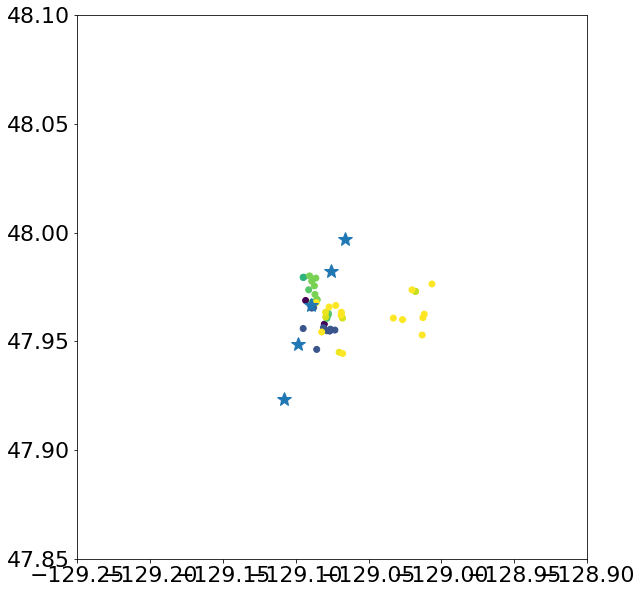

In [214]:
# Exercise - plot all of the cross-correlated clusters that have more than one event in them
group_evs = []
lats = []
lons = []
depths = []
group_nums = []
for i,group in enumerate(groups):
    if len(group)<2:
        continue
    eqs = obspy.core.event.Catalog()
    for ev in group:
        ev_id = ev[1]
        cat_ev = [ev for ev in cat_filt if ev.resource_id.id == ev_id]
        eqs.extend(cat_ev)
        lats.append(cat_ev[0].origins[0].latitude)
        lons.append(cat_ev[0].origins[0].longitude)
        depths.append(cat_ev[0].origins[0].depth)
        group_nums.append(i)
    group_evs.append(eqs)
    
vent_lon=[-129.098100000000,-129.089400000000,-129.075600000000,-129.108200000000,-129.066200000000]
vent_lat=[47.9487000000000,47.9666000000000,47.9822000000000,47.9233000000000,47.9969000000000] 

fig, ax = plt.subplots(1, 1,figsize=[10,10])
ax.scatter(lons,lats,c=group_nums)
ax.plot(vent_lon,vent_lat,marker='*',markersize=15,linestyle="none")
ax.set_xlim([-129.25,-128.9])
ax.set_ylim([47.85,48.1])
ax.set_aspect(1/0.67);

## Plot locations of spatially correlated groups by color

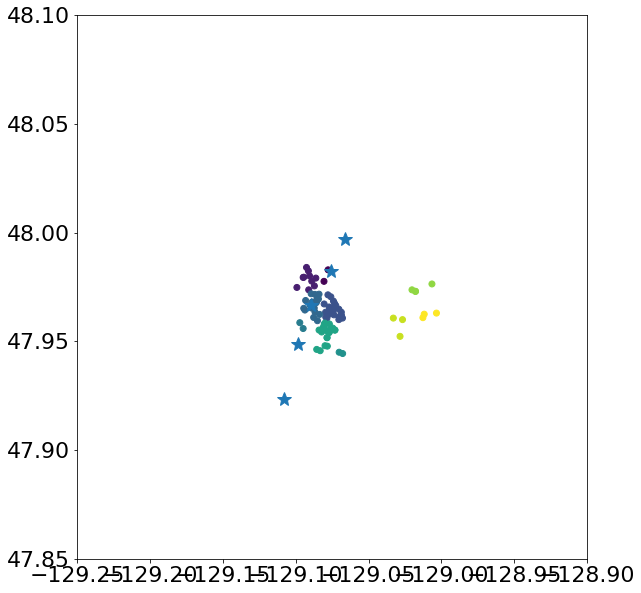

In [227]:
group_evs = []
lats = []
lons = []
depths = []
group_nums = []
for i,group in enumerate(groups_s):
    if len(group)<2:
        continue
    eqs = obspy.core.event.Catalog()
    for ev in group:
        cat_ev = ev
        eqs.append(cat_ev)
        lats.append(cat_ev.origins[0].latitude)
        lons.append(cat_ev.origins[0].longitude)
        depths.append(cat_ev.origins[0].depth)
        group_nums.append(i)
    group_evs.append(eqs)
    
vent_lon=[-129.098100000000,-129.089400000000,-129.075600000000,-129.108200000000,-129.066200000000]
vent_lat=[47.9487000000000,47.9666000000000,47.9822000000000,47.9233000000000,47.9969000000000] 

fig, ax = plt.subplots(1, 1,figsize=[10,10])
ax.scatter(lons,lats,c=group_nums)
ax.plot(vent_lon,vent_lat,marker='*',markersize=15,linestyle="none")
ax.set_xlim([-129.25,-128.9])
ax.set_ylim([47.85,48.1])
ax.set_aspect(1/0.67);

Next - figure out how to reconcile these two different clustering methods, OR just start with a simple multiplet example and carry that through more time like Felix suggested?

## Below is work starting 04/25

#### For pulling specific channels - set swin in Tribe().construct() to P_all and S_all

## NOTE: need to visually check this to match our desired template lengths before and after the picks, as decided in our moment estimation model.

In [5]:
# Start by making a tribe which stores the waveforms from all the picks in the catalog

from eqcorrscan import Tribe
client = Client("IRIS")
# Barrett got best performance with process_len=1 hour



tribe = Tribe().construct(
    method="from_client", lowcut=5.0, highcut=20.0, samp_rate=200.0, length=3.0,
    filt_order=4, prepick=0.25, client_id=client, catalog=cat_filt, data_pad=20.,
    process_len=3600, min_snr=3.0, parallel=True,swin='all')

# Can also specify parallel=True and num_cores

print(tribe)

Signal-to-noise ratio 1.3509487940018892 below threshold for ENWF.HHE, not using
No pick for NV.ENWF..HHE
Signal-to-noise ratio 1.3941193247295915 below threshold for ENWF.HHZ, not using
No pick for NV.ENWF..HHZ
Signal-to-noise ratio 1.5794058987499933 below threshold for KEMF.CN1, not using
No pick for NV.KEMF.W3.CN1
Signal-to-noise ratio 1.5473115008248732 below threshold for KEMF.CN2, not using
No pick for NV.KEMF.W3.CN2
Signal-to-noise ratio 1.1175652823580449 below threshold for NCHR.EHE, not using
No pick for NV.NCHR..EHE
Signal-to-noise ratio 2.002151171281633 below threshold for NCHR.EHZ, not using
No pick for NV.NCHR..EHZ
Signal-to-noise ratio 0.5266437659002337 below threshold for ENHR.HH2, not using
No pick for NV.ENHR..HH2
Signal-to-noise ratio 0.9502207517678669 below threshold for ENWF.HHE, not using
No pick for NV.ENWF..HHE
Signal-to-noise ratio 1.0155480361888007 below threshold for KEMF.CN2, not using
No pick for NV.KEMF.W3.CN2
Signal-to-noise ratio 0.4881298055555368 

Tribe of 62 templates


In [ ]:
# Can plot one of the sets of templates as follows
fig = tribe[2].st.plot(equal_scale=False, size=(800, 600))

In [30]:
# From that set of n templates, called a tribe, you can run cross correlation on continuous data downloaded from a client

# It outputs a party, which has n families, where n is the number of templates in the tribe
# If the family was used to make a successful detection, then that family has a list of detections saved with it
# The detections each have a catalog "event" object that stores the pick info, can be accessed as detection.event.picks

party, stream = tribe.client_detect(client=client, starttime=UTCDateTime(2019, 7, 10),endtime=UTCDateTime(2019, 7, 11), threshold=0.9, threshold_type='av_chan_corr',trig_int=6, plot=False, return_stream=True)

Last bit of data between 2019-07-10T00:59:54.250000Z and 2019-07-10T01:00:05.750000Z will go unused because it is shorter than a chunk of 3600.0 s
Last bit of data between 2019-07-10T01:59:54.250000Z and 2019-07-10T02:00:05.750000Z will go unused because it is shorter than a chunk of 3600.0 s
Last bit of data between 2019-07-10T02:59:54.250000Z and 2019-07-10T03:00:05.750000Z will go unused because it is shorter than a chunk of 3600.0 s
Last bit of data between 2019-07-10T03:59:54.250000Z and 2019-07-10T04:00:05.750000Z will go unused because it is shorter than a chunk of 3600.0 s
Last bit of data between 2019-07-10T04:59:54.250000Z and 2019-07-10T05:00:05.750000Z will go unused because it is shorter than a chunk of 3600.0 s
Last bit of data between 2019-07-10T05:59:54.250000Z and 2019-07-10T06:00:05.750000Z will go unused because it is shorter than a chunk of 3600.0 s
Last bit of data between 2019-07-10T06:59:54.250000Z and 2019-07-10T07:00:05.750000Z will go unused because it is shor

In [33]:
# See if there were any detections-- print out the index of the family with detections

for i,d in enumerate(party):
    if len(d) > 0:
        print(i)

53


In [36]:
party[53][0].event

Event:	

	   resource_id: ResourceIdentifier(id="2019_07_06t20_55_09_20190710T215415.350000")
	 creation_info: CreationInfo(author='EQcorrscan', creation_time=UTCDateTime(2022, 4, 26, 4, 13, 35, 139547))
	          ---------
	      comments: 4 Elements
	         picks: 6 Elements

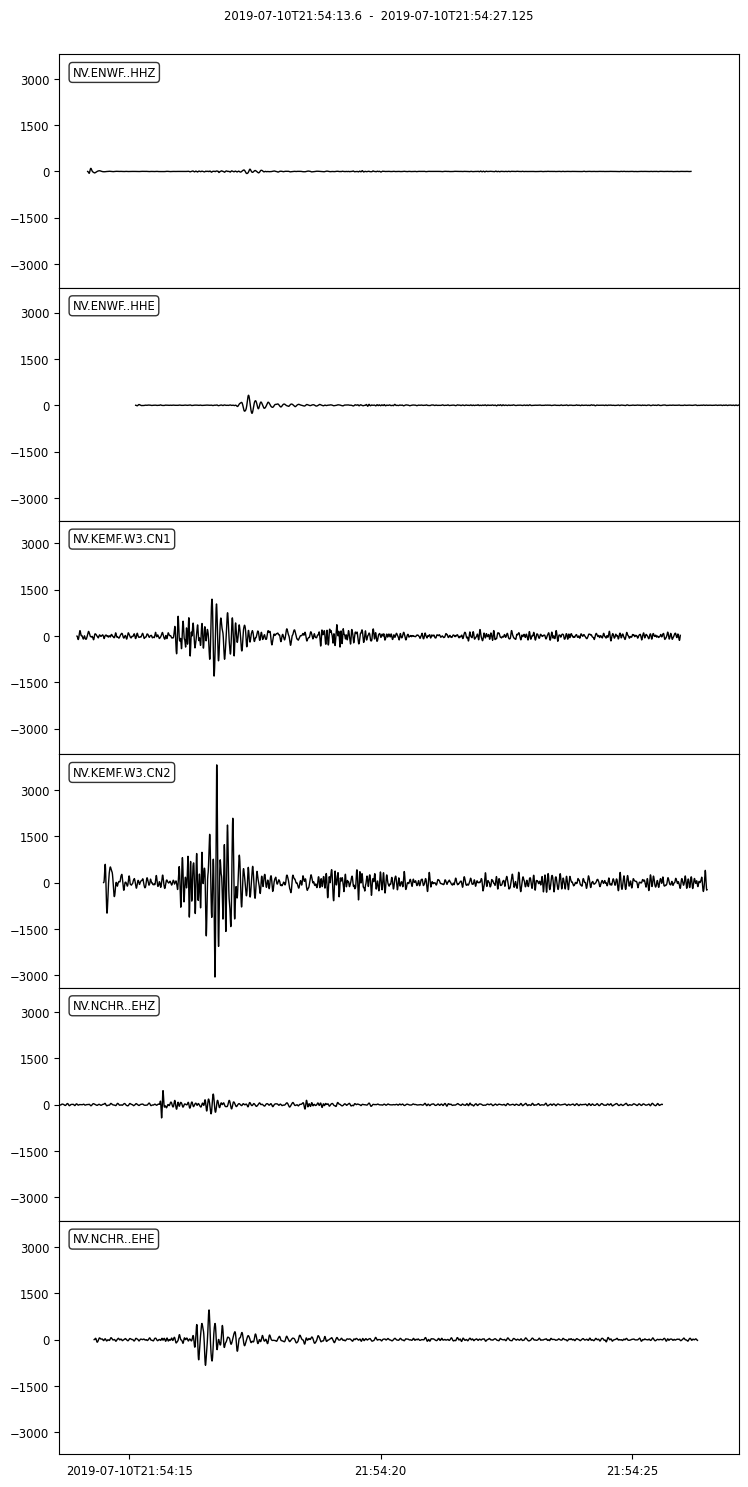

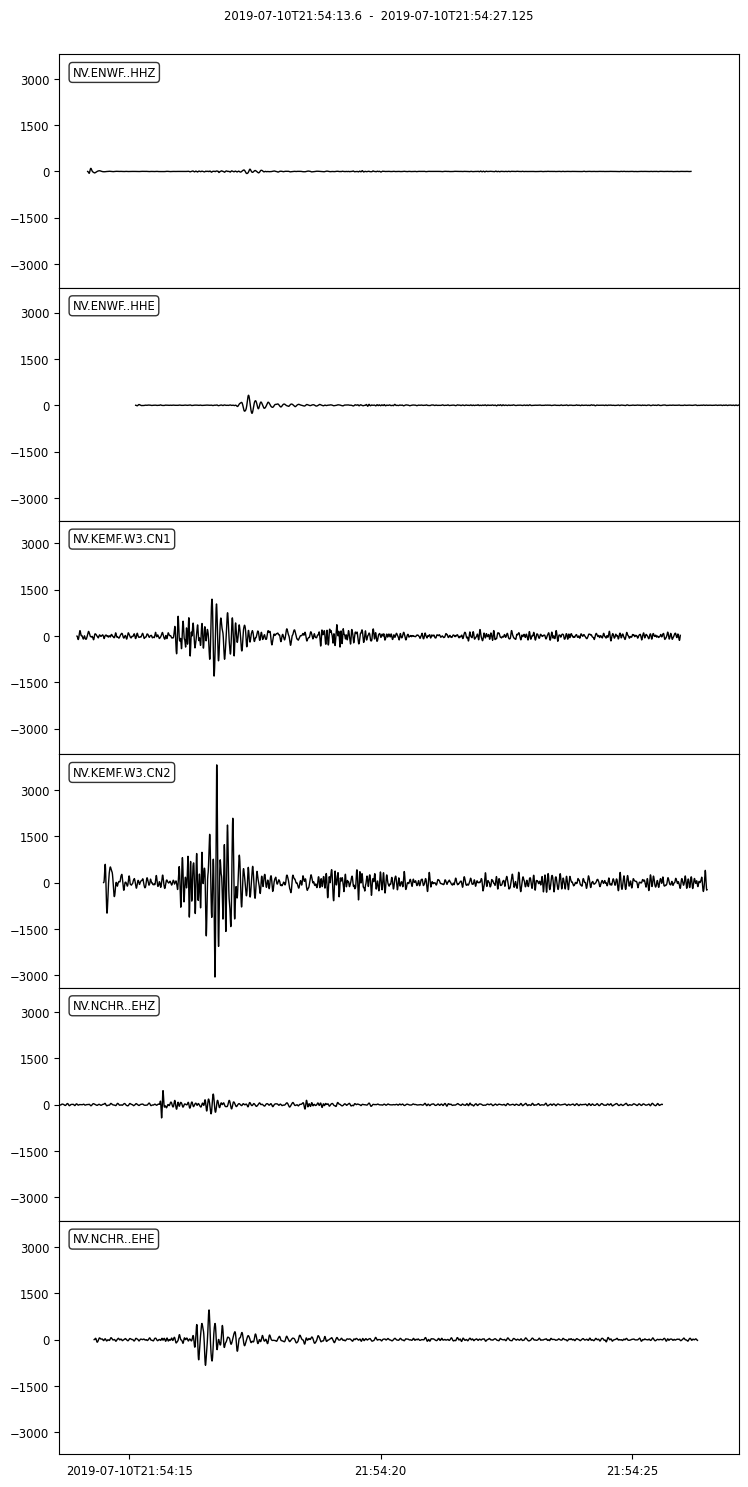

In [49]:
# Plot up the waveforms around those picks to visually check

test = party[53][0].extract_stream(stream,12,2)
# Filter to the same as the templates
test.filter('bandpass',freqmin=5,freqmax=20)
test.plot()